# Random Forests

In [1]:
import pandas as pd 
import numpy as np 
import random 
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

In [2]:
class RandomForestTree():
   
    def __init__(
        self,
        Y, 
        X, 
        min_samples_split=None,
        max_depth=None,
        depth=None,
        X_features_fraction=None,
        node_type=None,
        rule=None
    ):
        self.Y, self.X = Y, X

        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5
        self.depth = depth if depth else 0 
        self.features = list(X.columns)
        self.node_type = node_type if node_type else 'root' 
        self.rule = rule if rule else ""
 
        self.counts = Counter(Y)
        self.gini_impurity = self.get_GINI()
        self.n_features = len(self.features)
        self.X_features_fraction = X_features_fraction if X_features_fraction is not None else 1.0

        counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[1]))

        yhat = None
        if len(counts_sorted) > 0:
            yhat = counts_sorted[-1][0]

        self.yhat = yhat 
        self.n = len(Y)
        self.left = None 
        self.right = None 

        self.best_feature = None 
        self.best_value = None 
    
    def get_random_X_colsample(self):
        n_ft = int(self.n_features * self.X_features_fraction)
        feats = random.sample(self.features, n_ft) 
        X = self.X[feats].copy()
        return X 

    @staticmethod
    def GINI_impurity(y1_cnt: int, y2_cnt: int) -> float:
        if y1_cnt is None:
            y1_cnt = 0
        if y2_cnt is None:
            y2_cnt = 0

        n = y1_cnt + y2_cnt
        if n == 0:
            return 0.0

        p1 = y1_cnt / n
        p2 = y2_cnt / n
        gini = 1 - (p1 ** 2 + p2 ** 2)
        return gini

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        return np.convolve(x, np.ones(window), 'valid') / window

    def get_GINI(self):
        y1_cnt, y2_cnt = self.counts.get(0, 0), self.counts.get(1, 0)
        return self.GINI_impurity(y1_cnt, y2_cnt)

    def best_split(self) -> tuple:
        df = self.X.copy()
        df['Y'] = self.Y
 
        GINI_base = self.get_GINI()

        max_gain = 0
        best_feat = None
        best_val = None
 
        n_ft = int(self.n_features * self.X_features_fraction)

        features_subsample = random.sample(self.features, n_ft)

        for feature in features_subsample:
            Xdf = df.dropna().sort_values(feature)
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])

                y0_left, y1_left, y0_right, y1_right = left_counts.get(0, 0), left_counts.get(1, 0), right_counts.get(0, 0), right_counts.get(1, 0)

                gini_left = self.GINI_impurity(y0_left, y1_left)
                gini_right = self.GINI_impurity(y0_right, y1_right)

                n_left = y0_left + y1_left
                n_right = y0_right + y1_right
                w_left = n_left / (n_left + n_right)
                w_right = n_right / (n_left + n_right)

                wGINI = w_left * gini_left + w_right * gini_right
 
                GINIgain = GINI_base - wGINI

                if GINIgain > max_gain:
                    best_feat = feature
                    best_val = value  
                    max_gain = GINIgain

        return (best_feat, best_val)

    def grow_tree(self):
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            best_feat, best_val = self.best_split()

            if best_feat is not None:
                self.best_feature = best_feat
                self.best_value = best_val

                left_index, right_index = self.X[self.X[best_feat]<=best_val].index, self.X[self.X[best_feat]>best_val].index

                left_X, right_X = self.X[self.X.index.isin(left_index)], self.X[self.X.index.isin(right_index)]

                left_X.reset_index(inplace=True, drop=True)
                right_X.reset_index(inplace=True, drop=True)

                left_Y, right_Y = [self.Y[x] for x in left_index], [self.Y[x] for x in right_index]

                left = RandomForestTree(
                    left_Y, 
                    left_X, 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feat} <= {round(best_val, 3)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = RandomForestTree(
                    right_Y, 
                    right_X, 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feat} > {round(best_val, 3)}"
                    )

                self.right = right
                self.right.grow_tree()
    
    def predict(self, X:pd.DataFrame):
        predictions = []

        for _, x in X.iterrows():
            values = {}
            for feature in self.features:
                values.update({feature: x[feature]})
        
            predictions.append(self.predict_obs(values))
        
        return predictions

    def predict_obs(self, values: dict) -> int:
        cur_node = self
        while cur_node.depth < cur_node.max_depth:
            best_feature = cur_node.best_feature
            best_value = cur_node.best_value

            if (cur_node.n < cur_node.min_samples_split) | (best_feature is None):
                break 

            if (values.get(best_feature) < best_value):
                if self.left is not None:
                    cur_node = cur_node.left
            else:
                if self.right is not None:
                    cur_node = cur_node.right
            
        return cur_node.yhat

In [3]:
class RandomForestClassifier():
    def __init__(
        self,
        Y: list,
        X: pd.DataFrame,
        min_samples_split=None,
        max_depth=None,
        n_trees=None,
        X_features_fraction=None,
        X_obs_fraction=None
    ):
        self.Y = Y 
        self.X = X
        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5 
        self.features = list(X.columns)
        self.n_features = len(self.features)
        self.n_trees = n_trees if n_trees is not None else 30
        self.X_features_fraction = X_features_fraction if X_features_fraction is not None else 1.0
        self.X_obs_fraction = X_obs_fraction if X_obs_fraction is not None else 1.0

    def bootstrap_sample(self):
        Xbootstrap = self.X.sample(frac=self.X_obs_fraction, replace=True) 
        indexes = Xbootstrap.index
        Ybootstrap = [self.Y[x] for x in indexes]
        Xbootstrap.reset_index(inplace=True, drop=True)
        return Xbootstrap, Ybootstrap

    def grow_random_forest(self): 
        random_forest = []
        for _ in tqdm(range(self.n_trees)):
            X, Y = self.bootstrap_sample()
            tree = RandomForestTree(
                Y=Y, 
                X=X, 
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                X_features_fraction=self.X_features_fraction
                )
            tree.grow_tree()
            random_forest.append(tree)
        self.random_forest = random_forest

    def tree_predictions(self, X: pd.DataFrame) -> list:
        predictions = []
        for i in range(self.n_trees):
            yhat = self.random_forest[i].predict(X)
            predictions.append(yhat)
        return predictions
    
    def predict(self, X: pd.DataFrame) -> list:
        yhat = self.tree_predictions(X)
        n = X.shape[0] 
        yhat_final = []

        for i in range(n):
            yhat_obs = [x[i] for x in yhat] 
            counts = Counter(yhat_obs)
            most_common = counts.most_common(1)[0][0] 
            yhat_final.append(most_common)
        return yhat_final

In [4]:
features = list(range(57))
d = pd.read_csv("spam.data.txt", sep=" ", header=None, names=list(range(58)))

print(d.head())

     0     1     2    3     4     5     6     7     8     9   ...    48  \
0  0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.00   
1  0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.00   
2  0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.01   
3  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   
4  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   

      49   50     51     52     53     54   55    56  57  
0  0.000  0.0  0.778  0.000  0.000  3.756   61   278   1  
1  0.132  0.0  0.372  0.180  0.048  5.114  101  1028   1  
2  0.143  0.0  0.276  0.184  0.010  9.821  485  2259   1  
3  0.137  0.0  0.137  0.000  0.000  3.537   40   191   1  
4  0.135  0.0  0.135  0.000  0.000  3.537   40   191   1  

[5 rows x 58 columns]


In [5]:
train, test = train_test_split(d, test_size=0.3)

In [6]:

# Initiating the random forest object 
rf = RandomForestClassifier(
    Y=train.iloc[: , -1], 
    X=train[features],
    min_samples_split=5,
    max_depth=4,
    n_trees=10,
    X_features_fraction=0.5
    )

# Growing the random forest 
rf.grow_random_forest()


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:50<00:00, 47.05s/it]


In [7]:
# Making predictions
yhat = rf.predict(test[features])
test['yhat'] = yhat

# Measurring accuracy
precision = precision_score(test.iloc[: , -1], test['yhat'])
print(f"The training precision: {precision}")
recall = recall_score(test.iloc[: , -1], test['yhat'])
print(f"The training recall: {recall}")

# acc = accuracy_score(test.iloc[: , -1], test['yhat'])
# print(acc)

The training precision: 1.0
The training recall: 1.0


<ipython-input-7-1d0b3a571dad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat'] = yhat


In [8]:
print("{:.3f}".format(precision))
print("{:.3f}".format(recall))

1.000
1.000


Scikitlearn's builtin RandomForest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
# X, y = make_classification(n_samples=1000, n_features=4,
#                           n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
d = pd.read_csv("spam.data.txt", sep=" ", header=None, names=list(range(58)))
X=d.iloc[:,0:57].values
y=d.iloc[:,57].values
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3)
d.head(5)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [28]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [43]:
from sklearn.ensemble import RandomForestClassifier
classifier= RandomForestClassifier(n_estimators=20, random_state=0,max_features = 'sqrt')
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)

In [44]:
from sklearn.metrics import accuracy_score
import sklearn.metrics
print(accuracy_score(y_test,y_pred),sklearn.metrics.precision_score(y_test, y_pred, average = 'weighted'),sklearn.metrics.recall_score(y_test, y_pred, average = 'weighted') )

0.9485879797248371 0.9489318507203105 0.9485879797248371


In [45]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test,y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )



Confusion Matrix : 
 [[820  21]
 [ 50 490]]
Accuracy :  0.9485879797248371
Sensitivity :  0.9750297265160524


In [53]:
k=[]
for x in range(1,58):
    from sklearn.ensemble import RandomForestClassifier
    classifier= RandomForestClassifier(n_estimators=20, random_state=0,max_features = x)
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    from sklearn.metrics import accuracy_score
    import sklearn.metrics
    from sklearn.metrics import confusion_matrix

    cm1 = confusion_matrix(y_test,y_pred)
    total1=sum(sum(cm1))

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    k.append(sensitivity1)
print(k)


[0.9785969084423306, 0.9774078478002378, 0.9702734839476813, 0.9809750297265161, 0.9738406658739596, 0.9750297265160524, 0.9750297265160524, 0.9750297265160524, 0.9738406658739596, 0.9738406658739596, 0.9667063020214031, 0.9678953626634959, 0.9702734839476813, 0.9690844233055886, 0.9667063020214031, 0.9690844233055886, 0.9571938168846611, 0.9643281807372176, 0.9690844233055886, 0.9726516052318668, 0.9607609988109393, 0.9690844233055886, 0.9726516052318668, 0.9548156956004756, 0.9607609988109393, 0.9690844233055886, 0.9571938168846611, 0.9571938168846611, 0.9631391200951248, 0.9571938168846611, 0.9690844233055886, 0.9607609988109393, 0.9690844233055886, 0.9619500594530321, 0.9667063020214031, 0.9631391200951248, 0.9607609988109393, 0.9583828775267539, 0.9631391200951248, 0.9643281807372176, 0.93935790725327, 0.9607609988109393, 0.9678953626634959, 0.9655172413793104, 0.9619500594530321, 0.9667063020214031, 0.9655172413793104, 0.9690844233055886, 0.9714625445897741, 0.9714625445897741, 0

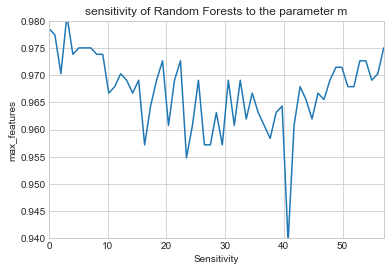

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.set(xlim=(0, 57), ylim=(0.94,0.98),
       xlabel='Sensitivity', ylabel='max_features',
       title='sensitivity of Random Forests to the parameter m')
x = np.linspace(0,57,57)
ax.plot(x, k)

4.(c)
OOB (out-of-bag) error

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were 

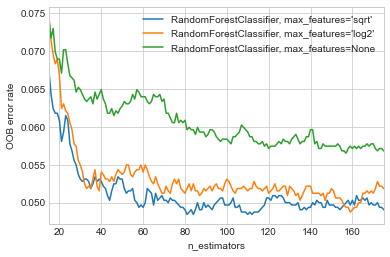

In [65]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train,y_train)
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))


for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [71]:
L=[]
for x in range(1,20,2):
    from sklearn.ensemble import RandomForestClassifier
    classifier= RandomForestClassifier(n_estimators=x, random_state=0,max_features = 'auto')
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    from sklearn.metrics import accuracy_score
    import sklearn.metrics
    from sklearn.metrics import confusion_matrix

    cm1 = confusion_matrix(y_test,y_pred)
    total1=sum(sum(cm1))

    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    L.append(accuracy1)
print(L)

[0.8298334540188269, 0.9174511223750905, 0.9312092686459088, 0.9312092686459088, 0.9304851556842868, 0.9333816075307748, 0.942795076031861, 0.944967414916727, 0.9471397538015931, 0.9471397538015931]


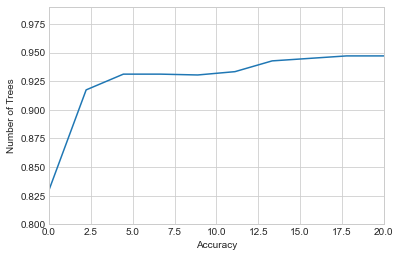

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.set(xlim=(0, 20), ylim=(0.8,0.99),
       xlabel='Accuracy', ylabel='Number of Trees')
x = np.linspace(0,20,10)
ax.plot(x, L)

In [77]:
H=[]
for x in range(1,20,2):
    from sklearn.ensemble import RandomForestClassifier
    classifier= RandomForestClassifier(n_estimators=x, random_state=0,max_features = 'log2')
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    from sklearn.metrics import accuracy_score
    import sklearn.metrics
    from sklearn.metrics import confusion_matrix

    cm1 = confusion_matrix(y_test,y_pred)
    total1=sum(sum(cm1))

    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    H.append(accuracy1)
print(H)

[0.8537291817523533, 0.8964518464880521, 0.9044170890658942, 0.9203475742215785, 0.9239681390296887, 0.9283128167994207, 0.9319333816075308, 0.9326574945691528, 0.9312092686459088, 0.9341057204923968]


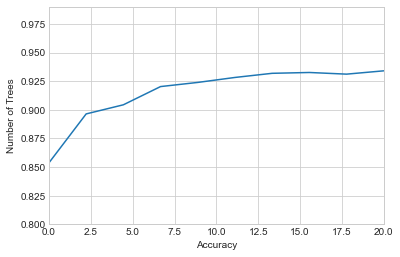

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.set(xlim=(0, 20), ylim=(0.8,0.99),
       xlabel='Accuracy', ylabel='Number of Trees')
x = np.linspace(0,20,10)
ax.plot(x, H)

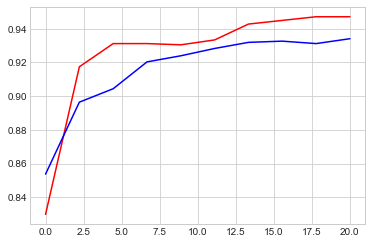

In [97]:
ax.set(xlim=(0, 20), ylim=(0.8,0.99),
       xlabel='Accuracy', ylabel='Number of Trees')
plt.plot(x, L, 'r') 
plt.plot(x, H, 'b')  
plt.show()